In [7]:
!git clone https://github.com/eladgsofer/clustering.git


fatal: destination path 'clustering' already exists and is not an empty directory.


In [8]:
!pip install tensorboardX
!pip install cytoolz

In [9]:
import sys

sys.path.append('/content/clustering')
sys.path.append('/content/clustering/examples/mnist')



In [11]:
import click
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
import argparse
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from tensorboardX import SummaryWriter
import uuid

from ptdec.dec_idec import DEC_IDEC
from ptdec.model import train, predict
from ptsdae.sdae import StackedDenoisingAutoEncoder
import ptsdae.model as ae
from ptdec.utils import cluster_accuracy

from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
class CachedMNIST(Dataset):
    def __init__(self, train, cuda, testing_mode=False):
        img_transform = transforms.Compose([transforms.Lambda(self._transformation)])
        self.ds = MNIST("./data", download=True, train=train, transform=img_transform)
        self.cuda = cuda
        self.testing_mode = testing_mode
        self._cache = dict()

    @staticmethod
    def _transformation(img):
        return torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float() * 0.02

    def __getitem__(self, index: int) -> torch.Tensor:
        if index not in self._cache:
            self._cache[index] = list(self.ds[index])
            if self.cuda:
                self._cache[index][0] = self._cache[index][0].cuda(non_blocking=True)
                self._cache[index][1] = torch.tensor(self._cache[index][1], dtype=torch.long).cuda(non_blocking=True)
        return self._cache[index]

    def __len__(self) -> int:
        return 128 if self.testing_mode else len(self.ds)

In [13]:
cuda=True
batch_size=256
pretrain_epochs=300
finetune_epochs=500
clustering_epochs=500
testing_mode=False

In [14]:
writer = SummaryWriter()  # create the TensorBoard object

# % cd /Users/elad.sofer/src/Engineering Project/pt-dec/examples/mnist; tensorboard --logdir=runs
# callback function to call during training, uses writer from the scope
def training_callback(epoch, lr, loss, validation_loss):
    writer.add_scalars("data/autoencoder", {"lr": lr, "loss": loss, "validation_loss": validation_loss, }, epoch)

ds_train = CachedMNIST(train=True, cuda=cuda, testing_mode=testing_mode)
ds_val = CachedMNIST(train=False, cuda=cuda, testing_mode=testing_mode)
autoencoder = StackedDenoisingAutoEncoder([28 * 28, 500, 500, 2000, 10], final_activation=None, mode=)
if cuda:
    autoencoder.cuda()


SyntaxError: ignored

In [ ]:
print("Pretraining stage.")
ae.pretrain(ds_train, autoencoder,
            cuda=cuda, validation=ds_val,
            epochs=pretrain_epochs, batch_size=batch_size,
            optimizer=lambda model: SGD(model.parameters(), lr=0.1, momentum=0.9),
            scheduler=lambda x: StepLR(x, 100, gamma=0.1), corruption=0.2, update_freq=50)

torch.save(autoencoder, 'ae_pretrain.pt')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Pretraining stage.


  0%|          | 0/235 [00:00<?, ?batch/s, epo=0, lss=0.000000, vls=-1.000000]<ipython-input-5-fb4169d95fb8>:11: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float() * 0.02
100%|██████████| 235/235 [00:01<00:00, 228.94batch/s, epo=299, lss=0.004187, vls=0.004147]


In [ ]:
print("Training stage.")
ae_optimizer = SGD(params=autoencoder.parameters(), lr=0.1, momentum=0.9)
ae.train(ds_train, autoencoder,
          cuda=cuda, validation=ds_val,
          epochs=finetune_epochs, batch_size=batch_size,update_freq=50,
          optimizer=ae_optimizer, scheduler=StepLR(ae_optimizer, 100, gamma=0.1),
          corruption=0.2, update_callback=training_callback, )
torch.save(autoencoder, 'ae_train.pt')
writer.flush()

Training stage.


100%|██████████| 235/235 [00:01<00:00, 200.06batch/s, epo=499, lss=0.281117, vls=0.308311]


DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 587.07batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 135.30batch/s, acc=0.8336, dlb=0.0000, epo=137, lss=0.03235309]


Early stopping as label delta "0.00000" less than "0.00000".
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.085s...
[t-SNE] Computed neighbors for 60000 samples in 9.643s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 120

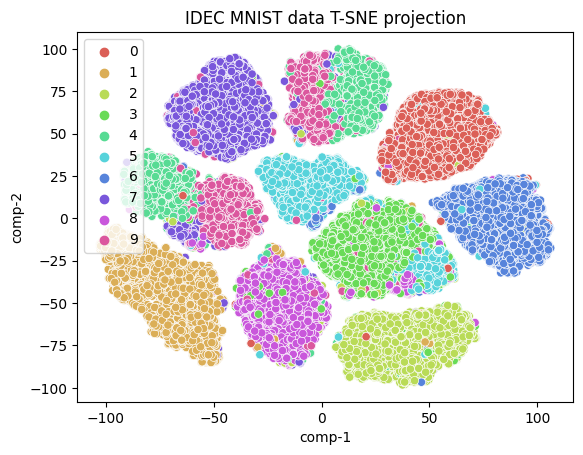

Final DEC accuracy: 0.83355


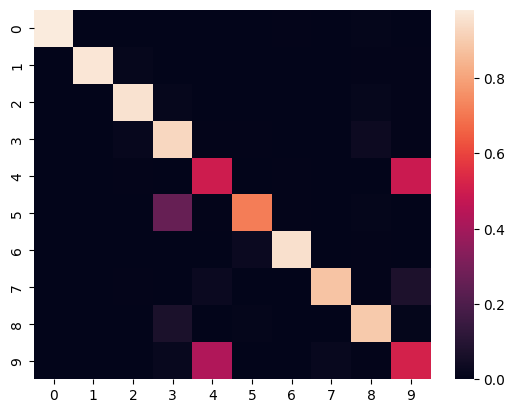

Writing out confusion diagram with UUID: 25af4200e70f451e92fd3a6ea59184ed
DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 644.03batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 129.23batch/s, acc=0.8545, dlb=0.0000, epo=231, lss=0.04219645]


Early stopping as label delta "0.00000" less than "0.00000".
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.084s...
[t-SNE] Computed neighbors for 60000 samples in 8.668s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 120

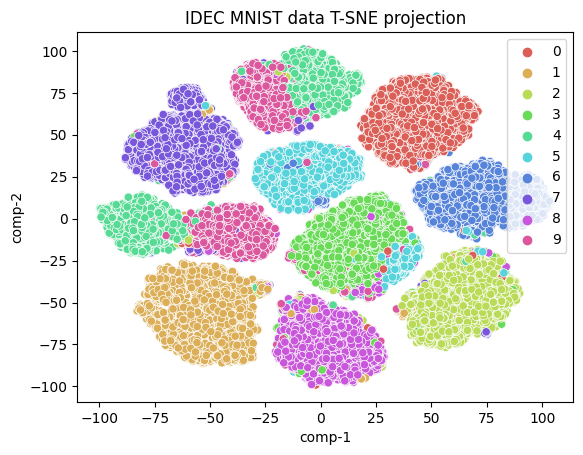

Final DEC accuracy: 0.85445


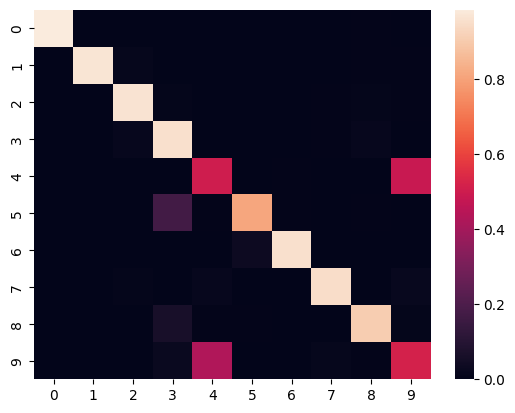

Writing out confusion diagram with UUID: 27b7632af00841248c9bde9c82688859
DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 672.56batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 134.70batch/s, acc=0.8654, dlb=0.0001, epo=448, lss=0.03826534]


Early stopping as label delta "0.00000" less than "0.00000".
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.080s...
[t-SNE] Computed neighbors for 60000 samples in 9.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 120

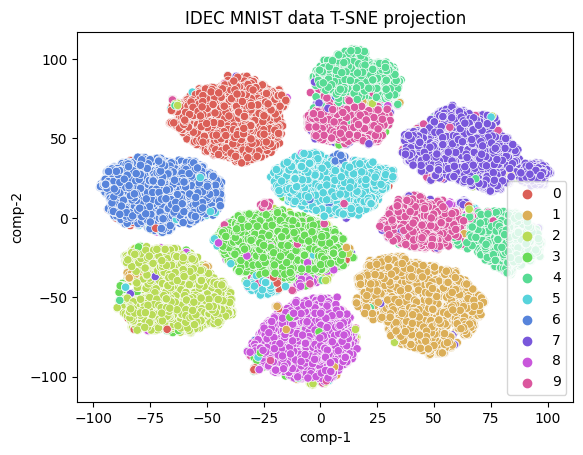

Final DEC accuracy: 0.8654


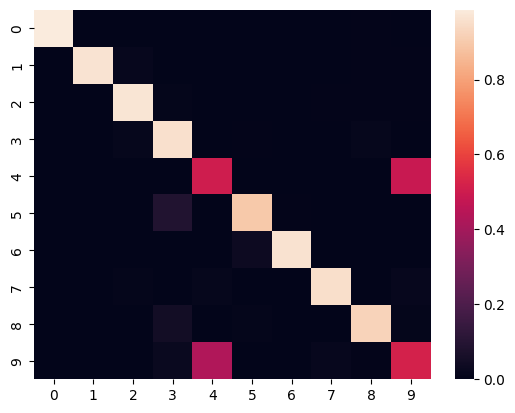

Writing out confusion diagram with UUID: 08d8e252f06a4b169300e3fb9b881b5b
DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 667.77batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 132.49batch/s, acc=0.8696, dlb=0.0003, epo=499, lss=0.04654710]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.081s...
[t-SNE] Computed neighbors for 60000 samples in 8.858s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

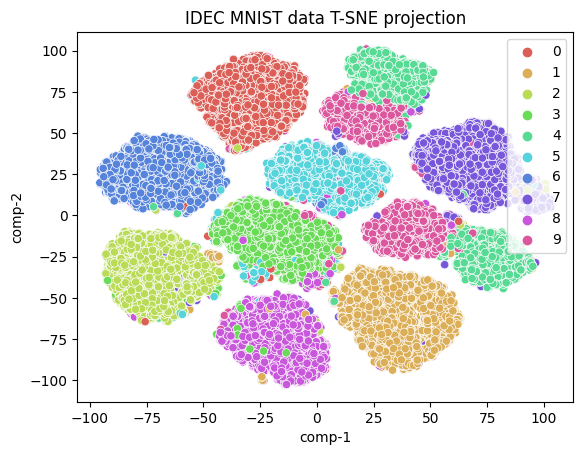

Final DEC accuracy: 0.8696666666666667


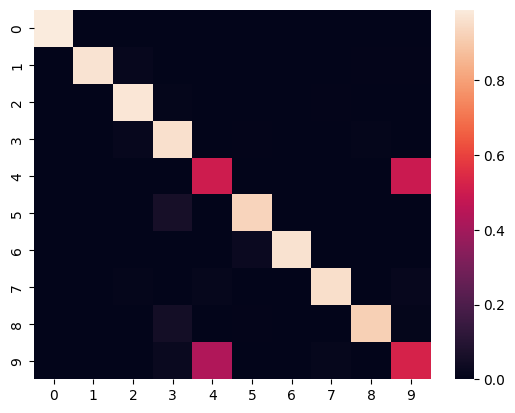

Writing out confusion diagram with UUID: b0a6df0cb2ed4cd9994114510dbe729f
DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 661.26batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 132.06batch/s, acc=0.8712, dlb=0.0004, epo=499, lss=0.04964514]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.080s...
[t-SNE] Computed neighbors for 60000 samples in 8.992s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

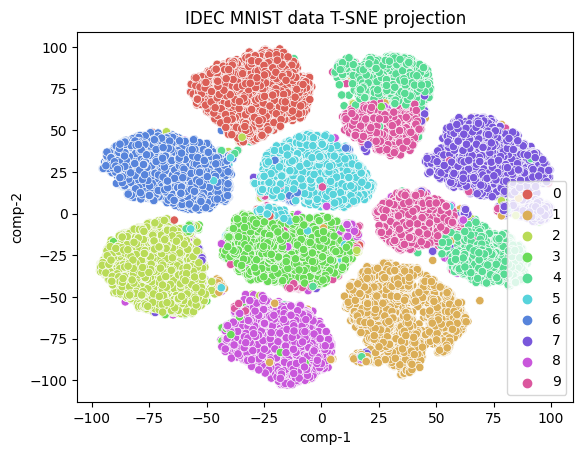

Final DEC accuracy: 0.8713


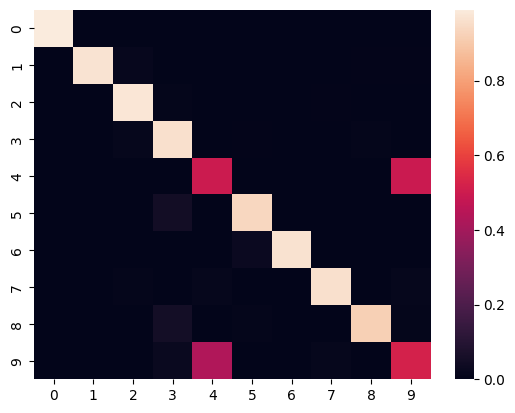

Writing out confusion diagram with UUID: f2df40bca8844c3bb9fd606d7b5a112f
DEC/IDEC stage.


100%|██████████| 235/235 [00:00<00:00, 672.92batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 235/235 [00:01<00:00, 132.83batch/s, acc=0.8711, dlb=0.0007, epo=499, lss=0.06921942]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.079s...
[t-SNE] Computed neighbors for 60000 samples in 8.932s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

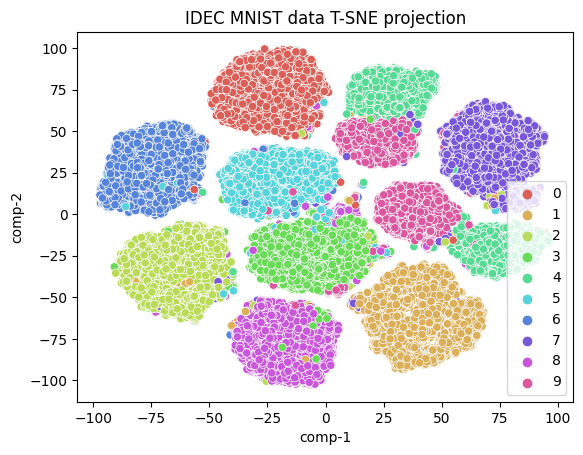

Final DEC accuracy: 0.8711333333333333


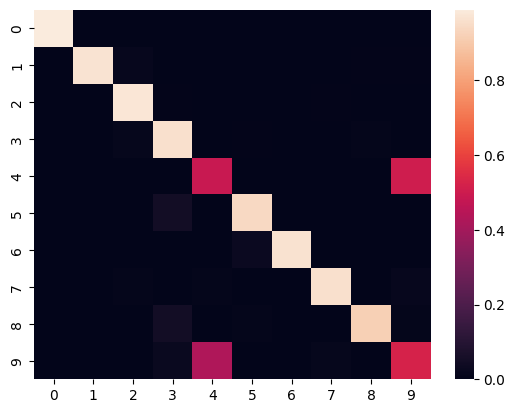

Writing out confusion diagram with UUID: c98ed553c5be4ede8235fd9b9eddaa93


In [ ]:
for lambda_ in np.linspace(0.2,4, 6):
  print("DEC/IDEC stage.")
  autoencoder = torch.load('ae_train.pt')
  model = DEC_IDEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder, decoder=autoencoder.decoder,
                  mode='IDEC', lambda_=lambda_.item())
  if cuda:
    model.cuda()
  dec_optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
  train(dataset=ds_train, model=model, epochs=clustering_epochs,update_freq=50,
      batch_size=256, optimizer=dec_optimizer, stopping_delta=0.000001, cuda=cuda, )
  torch.save(model, 'dec{0}.pt'.format(lambda_.item()))

  predicted, actual, embeddings = predict(ds_train, model, 1024, silent=True, return_actual=True, cuda=cuda,
                                          return_embeddings=True)
  actual = actual.cpu().numpy()
  predicted = predicted.cpu().numpy()

  tsne = TSNE(n_components=2, verbose=1, random_state=123)
  z = tsne.fit_transform(embeddings)
  df = pd.DataFrame()
  df["y"] = actual
  df["comp-1"] = z[:, 0]
  df["comp-2"] = z[:, 1]
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                  palette=sns.color_palette("hls", 10),
                  data=df).set(title="{0} MNIST data T-SNE projection".format(model.mode))
  plt.show()

  reassignment, accuracy = cluster_accuracy(actual, predicted)

  print("Final DEC accuracy: %s" % accuracy)
  if not testing_mode:
      predicted_reassigned = [reassignment[item] for item in predicted]  # TODO numpify
      confusion = confusion_matrix(actual, predicted_reassigned)
      normalised_confusion = (confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis])
      confusion_id = uuid.uuid4().hex
      sns.heatmap(normalised_confusion).get_figure().savefig("confusion_%s.png" % confusion_id)
      plt.show()
      print("Writing out confusion diagram with UUID: %s" % confusion_id)
      writer.close()


